In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
tweet = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

Text(0, 0.5, 'sample')

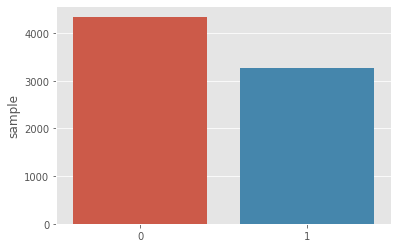

In [4]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('sample')

# Preprocess

In [5]:
df = pd.concat([tweet, test])

In [6]:
# Fill NaN value of keword column and location column
df.keyword = df.keyword.fillna('NoKeword')
df.location = df.location.fillna('NoLocation')

In [7]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [8]:
df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [9]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_html(x))

In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text'] = df['text'].apply(lambda x : remove_emoji(x))

In [11]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text'] = df['text'].apply(lambda x : remove_punct(x))

In [12]:
df

,id,keyword,location,text,target
0,1,NoKeword,NoLocation,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NoKeword,NoLocation,Forest fire near La Ronge Sask Canada,1.0
2,5,NoKeword,NoLocation,All residents asked to shelter in place are be...,1.0
3,6,NoKeword,NoLocation,13000 people receive wildfires evacuation orde...,1.0
4,7,NoKeword,NoLocation,Just got sent this photo from Ruby Alaska as s...,1.0
...,...,...,...,...,...
3258,10861,NoKeword,NoLocation,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NoKeword,NoLocation,Storm in RI worse than last hurricane My citya...,NaN
3260,10868,NoKeword,NoLocation,Green Line derailment in Chicago,NaN
3261,10874,NoKeword,NoLocation,MEG issues Hazardous Weather Outlook HWO,NaN


In [13]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.5 MB/s eta 0:00:00


In [14]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    
    for word in text.split():
        for word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return " ".join(corrected_text)

In [15]:
def Make_new_text(keyword,location,text):
    return str(keyword) + ' ' + str(location) + ' ' + str(text)

df['New_text'] = df.apply(lambda x: Make_new_text(x.keyword, x.location, x.text), axis=1)

In [16]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['New_text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) & (word not in stop))]
        
        corpus.append(words)
        
    return corpus

In [17]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 6648.12it/s]


In [18]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()

In [19]:
tokenizer_obj.fit_on_texts(corpus)

In [20]:
sequences = tokenizer_obj.texts_to_sequences(corpus)

In [21]:
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [22]:
tweet_pad[1].shape

(50,)